# SES Convolution

This notebook explores how the SES can be used to build the charge distributions at higher charges. This can be approached in two ways: a Monte Carlo approach where the SES is sampled, or through the construction of the PDF by convolving the SES with itself.

Firstly, we define the SES for a simple PMT and SiPM:

In [1]:
import numpy as np
from numba import njit, prange, vectorize, int64, float64
from math import lgamma, exp, pow, sqrt, log, pi
from functools import partial
from scipy.stats import poisson
from scipy.signal import convolve
from matplotlib import pyplot as plt
from tqdm import trange
%matplotlib inline

In [2]:
SQRT2PI = sqrt(2.0 * pi) 

@vectorize([float64(float64, float64, float64)], fastmath=True)
def normal_pdf(x, mean=0, std_deviation=1):
    u = (x - mean) / std_deviation
    return exp(-0.5 * u ** 2) / (SQRT2PI * std_deviation)

In [3]:
# PMT SES Definition
@njit(fastmath=True, parallel=True)
def pmt_ses(x, spe, spe_sigma):
    pe_sigma = sqrt(spe_sigma ** 2)
    pe_signal = normal_pdf(x, spe, pe_sigma)
    return pe_signal

In [4]:
# SiPM SES Definition
@njit(fastmath=True, parallel=True)
def sipm_ses(x, spe, spe_sigma, opct):
    pe_signal = np.zeros(x.size)
    # Loop over the possible total number of cells fired
    for k in prange(1, 250):
        pk = (1-opct) * pow(opct, k-1)

        # Combine spread of pedestal and pe (and afterpulse) peaks
        pe_sigma = np.sqrt(k * spe_sigma ** 2)

        # Evaluate probability at each value of x
        pe_signal += pk * normal_pdf(x, k * spe, pe_sigma)

    return pe_signal

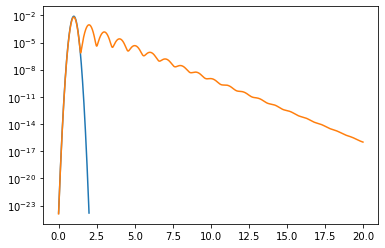

In [5]:
# Define input parameters
spe=1
spe_sigma=0.1
opct=0.2

# Obtain pdfs
x_pmt = np.linspace(0, 2, 1000)
pdf_pmt = pmt_ses(x_pmt, spe, spe_sigma)

x_sipm = np.linspace(0, 20, 10000)
pdf_sipm = sipm_ses(x_sipm, spe, spe_sigma, opct)

pdf_pmt /= pdf_pmt.sum()
pdf_sipm /= pdf_sipm.sum()

plt.semilogy(x_pmt, pdf_pmt)
plt.semilogy(x_sipm, pdf_sipm)

In [6]:
np.average(x_pmt, weights=pdf_pmt)
np.average(x_sipm, weights=pdf_sipm)

1.2499999999993496

In [7]:
n_pe = 1
n_events = 100000

## Monte Carlo Approach

This approach samples from the SES, and sums together the n_pe samples to generate a representative charge.

In [8]:
np.random.choice(x_pmt, 5, p=pdf_pmt)

array([0.98698699, 0.81081081, 0.97697698, 0.93493493, 0.8988989 ])

Average: 1.00, Variance: 0.01, STD: 0.10


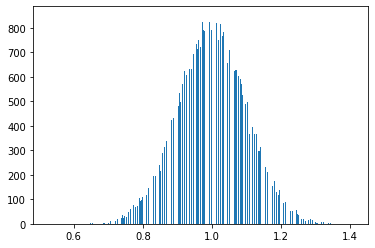

In [9]:
single_pe_charge = np.random.choice(x_pmt, (n_events, n_pe), p=pdf_pmt)
charge = single_pe_charge.sum(1)
print(f"Average: {np.mean(charge):.2f}, Variance: {np.var(charge):.2f}, STD: {np.std(charge):.2f}")
_ = plt.hist(charge, bins=1000)

Average: 1.25, Variance: 0.33, STD: 0.57


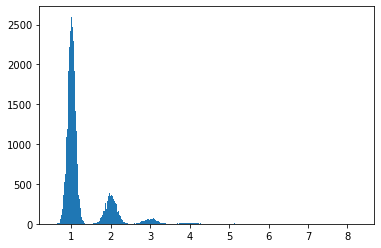

In [10]:
single_pe_charge = np.random.choice(x_sipm, (n_events, n_pe), p=pdf_sipm)
charge = single_pe_charge.sum(1)
print(f"Average: {np.mean(charge):.2f}, Variance: {np.var(charge):.2f}, STD: {np.std(charge):.2f}")
_ = plt.hist(charge, bins=1000)

## Statistical Approach

This approach convolves the SES with itself n_pe times to produce the PDF for when N photoelectrons are generated.

In [11]:
def pdf_convolve(n_pe, x, pdf):
    n_pe_pdf = pdf
    for i_pe in range(n_pe-1):
        n_pe_pdf = convolve(n_pe_pdf, pdf, mode='full')
    n_pe_x = np.linspace(0, n_pe*x.max(), n_pe_pdf.size)
    return n_pe_x, n_pe_pdf

In [12]:
def print_stats(x, y):
    avg = np.average(x, weights=y)
    var = np.average((x-avg)**2, weights=y)
    print(f"Average: {avg:.2f}, Variance: {var:.2f}, STD: {np.sqrt(var):.2f}")

Average: 1.00, Variance: 0.01, STD: 0.10


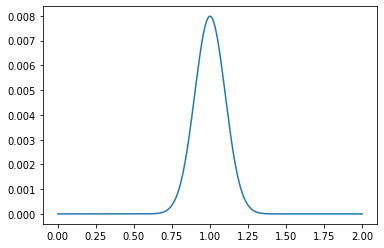

In [13]:
xn, pdfn = pdf_convolve(n_pe, x_pmt, pdf_pmt)
print_stats(xn, pdfn)
plt.plot(xn, pdfn)

Average: 1.25, Variance: 0.32, STD: 0.57


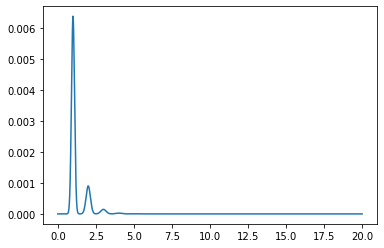

In [14]:
xn, pdfn = pdf_convolve(n_pe, x_sipm, pdf_sipm)
print_stats(xn, pdfn)
plt.plot(xn, pdfn)

# Poisson

Its important to note that the above investigations were considering the case where N photoelectrons were produced for certain. In reality, we only know the average illumination level, and the charge spectrum is built from the poisson fluctuations about that average. The SES distirbution is not independant from the poisson distribution, therefore we cannot convolve the two. The simplest approach is to use Monte Carlo:

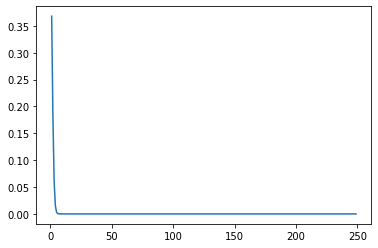

In [15]:
k = np.arange(1, 250)
poisson_pmf = poisson.pmf(k, n_pe)
plt.plot(k, poisson_pmf)

In [16]:
@njit(parallel=True)
def sample_ses(ses_x, ses_pdf, pe_array):
    n_events = pe_array.size
    charge = np.zeros(n_events)
    for iev in prange(n_events):
        for _ in prange(pe_array[iev]):
            # Equivalent to np.random.choice(ses_x, p=ses_pdf)
            charge[iev] += ses_x[np.searchsorted(np.cumsum(ses_pdf), np.random.random(), side="right")]
    return charge

Average: 1.00, Variance: 1.01, STD: 1.00


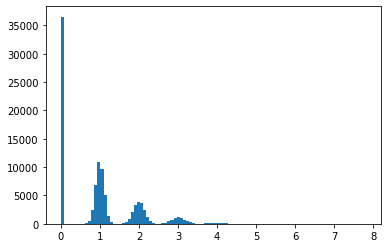

In [17]:
pe_array = poisson.rvs(n_pe, size=n_events)
charge = sample_ses(x_pmt, pdf_pmt, pe_array)
#charge = charge[charge != 0]
print(f"Average: {np.mean(charge):.2f}, Variance: {np.var(charge):.2f}, STD: {np.std(charge):.2f}")
_ = plt.hist(charge, bins=100)

Average: 1.25, Variance: 1.88, STD: 1.37


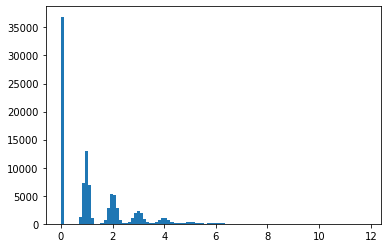

In [18]:
pe_array = poisson.rvs(n_pe, size=n_events)
charge = sample_ses(x_sipm, pdf_sipm, pe_array)
print(f"Average: {np.mean(charge):.2f}, Variance: {np.var(charge):.2f}, STD: {np.std(charge):.2f}")
_ = plt.hist(charge, bins=100)

## PDF with Poisson

Due to the inability to obtain the PDF of these distributions with simple convolutions, lets try the analytical description of the SPE (without the electronic noise):

In [19]:
@vectorize([float64(int64, float64)], fastmath=True)
def poisson_pmf(k, mu):
    return exp(k * log(mu) - mu - lgamma(k + 1))

@vectorize([float64(int64, int64)], fastmath=True)
def binom(n, k):
    return exp(lgamma(n + 1) - lgamma(k + 1) - lgamma(n - k + 1))

In [20]:
@njit(fastmath=True, parallel=True)
def pmt_spe_nn(x, spe, spe_sigma, lambda_):    
    # Obtain pedestal peak
    p_ped = exp(-lambda_)
    pe_signal = p_ped * normal_pdf(x, 0, 0.01)  # Approximate delta function

    # Loop over the possible total number of cells fired
    found = False
    for k in prange(1, 250):
        p = poisson_pmf(k, lambda_)  # Probability to get k avalanches

        # Skip insignificant probabilities
        if (not found) & (p < 1e-4):
            continue
        if found & (p < 1e-4):
            break
        found = True

        # Combine spread of pedestal and pe peaks
        pe_sigma = sqrt(k * spe_sigma ** 2)

        # Evaluate probability at each value of x
        pe_signal += p * normal_pdf(x, k * spe, pe_sigma)

    return pe_signal

In [21]:
@njit(fastmath=True, parallel=True)
def sipm_spe_nn(x, spe, spe_sigma, lambda_, opct):
    # Obtain pedestal peak
    p_ped = exp(-lambda_)
    pe_signal = p_ped * normal_pdf(x, 0, 0.001) # Approximate delta function

    # Loop over the possible total number of cells fired
    found = False
    for k in prange(1, 250):
        pk = 0
        for j in prange(1, k+1):
            pj = poisson_pmf(j, lambda_)  # Probability for j initial fired cells

            # Skip insignificant probabilities
            if pj < 1e-4:
                continue

            # Sum the probability from the possible combinations which result
            # in a total of k fired cells to get the total probability of k
            # fired cells
            pk += pj * pow(1-opct, j) * pow(opct, k-j) * binom(k-1, j-1)
            
        # Skip insignificant probabilities
        if (not found) & (pk < 1e-4):
            continue
        if found & (pk < 1e-4):
            break
        found = True
        
        pe_sigma = np.sqrt(k * spe_sigma ** 2)
        pe_signal += pk * normal_pdf(x, k * spe, pe_sigma)

    return pe_signal

Average: 1.00, Variance: 1.01, STD: 1.00


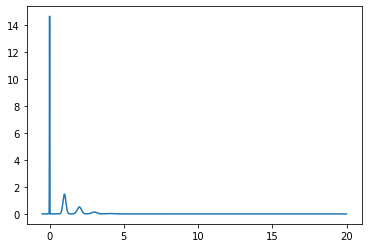

In [22]:
x_pmt_spe_nn = np.linspace(-0.5, 20, 10000)
pdf_pmt_spe_nn = pmt_spe_nn(x_pmt_spe_nn, spe, spe_sigma, n_pe)
print_stats(x_pmt_spe_nn, pdf_pmt_spe_nn)
plt.plot(x_pmt_spe_nn, pdf_pmt_spe_nn)

Average: 1.24, Variance: 1.88, STD: 1.37


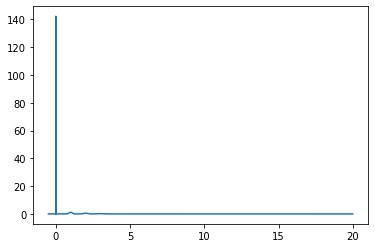

In [23]:
x_sipm_spe_nn = np.linspace(-0.5, 20, 10000)
pdf_sipm_spe_nn = sipm_spe_nn(x_sipm_spe_nn, spe, spe_sigma, n_pe, opct)
print_stats(x_sipm_spe_nn, pdf_sipm_spe_nn)
plt.plot(x_sipm_spe_nn, pdf_sipm_spe_nn)

# Electronic Noise

As electronic noise component can also be explicitely included in the PDF formula.

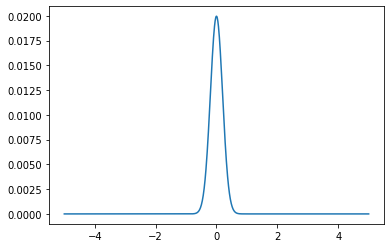

In [24]:
eped = 0
eped_sigma=0.2

x_eped = np.linspace(-5, 5, 1000)
pdf_eped = normal_pdf(x_eped, eped, eped_sigma)
pdf_eped /= pdf_eped.sum()

plt.plot(x_eped, pdf_eped)

## MC

Average: 1.00, Variance: 1.05, STD: 1.02


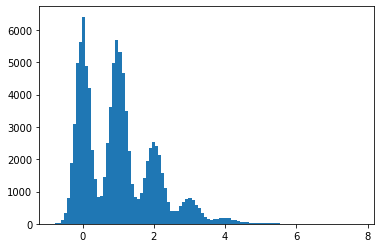

In [25]:
pe_array = poisson.rvs(n_pe, size=n_events)
charge = sample_ses(x_pmt, pdf_pmt, pe_array)
charge += np.random.choice(x_eped, charge.size, p=pdf_eped)
print(f"Average: {np.mean(charge):.2f}, Variance: {np.var(charge):.2f}, STD: {np.std(charge):.2f}")
_ = plt.hist(charge, bins=100)

Average: 1.25, Variance: 1.93, STD: 1.39


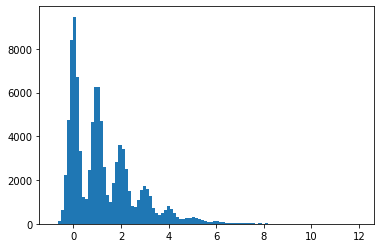

In [26]:
pe_array = poisson.rvs(n_pe, size=n_events)
charge = sample_ses(x_sipm, pdf_sipm, pe_array)
charge += np.random.choice(x_eped, charge.size, p=pdf_eped)
print(f"Average: {np.mean(charge):.2f}, Variance: {np.var(charge):.2f}, STD: {np.std(charge):.2f}")
_ = plt.hist(charge, bins=100)

## SPE Equation

In [27]:
@njit(fastmath=True, parallel=True)
def pmt_spe(x, eped, eped_sigma, spe, spe_sigma, lambda_):    
    # Obtain pedestal peak
    p_ped = exp(-lambda_)
    pe_signal = p_ped * normal_pdf(x, eped, eped_sigma)


    # Loop over the possible total number of cells fired
    found = False
    for k in prange(1, 250):
        p = poisson_pmf(k, lambda_)  # Probability to get k avalanches

        # Skip insignificant probabilities
        if (not found) & (p < 1e-4):
            continue
        if found & (p < 1e-4):
            break
        found = True

        pe_sigma = sqrt(k * spe_sigma ** 2 + eped_sigma ** 2)
        pe_signal += p * normal_pdf(x, eped + k * spe, pe_sigma)

    return pe_signal

In [28]:
@njit(fastmath=True, parallel=True)
def sipm_spe(x, eped, eped_sigma, spe, spe_sigma, lambda_, opct):
    # Obtain pedestal peak
    p_ped = exp(-lambda_)
    pe_signal = p_ped * normal_pdf(x, eped, eped_sigma)

    # Loop over the possible total number of cells fired
    found = False
    for k in prange(1, 250):
        pk = 0
        for j in prange(1, k+1):
            pj = poisson_pmf(j, lambda_)  # Probability for j initial fired cells

            # Skip insignificant probabilities
            if pj < 1e-4:
                continue

            # Sum the probability from the possible combinations which result
            # in a total of k fired cells to get the total probability of k
            # fired cells
            pk += pj * pow(1-opct, j) * pow(opct, k-j) * binom(k-1, j-1)
            
        # Skip insignificant probabilities
        if (not found) & (pk < 1e-4):
            continue
        if found & (pk < 1e-4):
            break
        found = True
        
        pe_sigma = sqrt(k * spe_sigma ** 2 + eped_sigma ** 2)
        pe_signal += pk * normal_pdf(x, eped + k * spe, pe_sigma)

    return pe_signal

Average: 1.00, Variance: 1.05, STD: 1.02


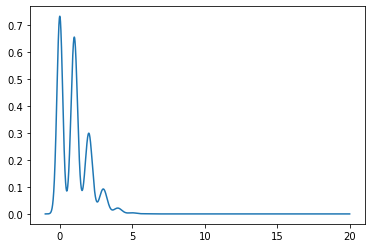

In [29]:
x_pmt_spe = np.linspace(-1, 20, 10000)
pdf_pmt_spe = pmt_spe(x_pmt_spe, eped, eped_sigma, spe, spe_sigma, n_pe)
print_stats(x_pmt_spe, pdf_pmt_spe)
plt.plot(x_pmt_spe, pdf_pmt_spe)

Average: 1.25, Variance: 1.92, STD: 1.38


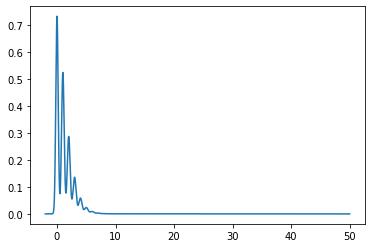

In [30]:
x_sipm_spe = np.linspace(-2, 50, 100000)
pdf_sipm_spe = sipm_spe(x_sipm_spe, eped, eped_sigma, spe, spe_sigma, n_pe, opct)
print_stats(x_sipm_spe, pdf_sipm_spe)
plt.plot(x_sipm_spe, pdf_sipm_spe)

In [31]:
np.average(x_sipm, weights=pdf_sipm)

1.2499999999993496

In [32]:
np.average(x_sipm_spe, weights=pdf_sipm_spe) / n_pe

1.2487997357216423